# Setup

In [1]:
import random
import string
import os

from pylibdmtx.pylibdmtx import encode, decode
from PIL import Image

from ultralytics import YOLO, settings
root_dir = os.getcwd().replace('\\notebooks', '')
settings.update({'datasets_dir': f'{root_dir}/data/module_pose/simple_synth', 'runs_dir': f'{root_dir}/yolo/runs'})
print(root_dir)

c:\Users\aidan\OneDrive\Desktop\itu\msc\courses\sem4\thesis\msc-thesis


In [2]:
# Should print True if GPU is available for use
import torch
print(torch.cuda.is_available())

True


# Simple Synthesis

Synthesizing a simple DMC dataset for the ultralytics yolo11 model to use.

In [3]:
def gen_string():
    '''
    Generates a serial number to encode
    
    Serial numbers are:
    - 11 characters long
    - Index 0, 2, 4, 5, 6, 7, 8, 9, 10 are random digits
    - Index 1 and 3 are uppercase letters
    - Index 11, 12, 13, 14 are an incremental number starting from 0001

    Example serial number: 4 L 4 N 0418028 0001
    '''

    to_encode = ''

    # first 11 indexes
    for j in range(11):
        # 1 and 3 are uppercase
        if j in [1, 3]:
            to_encode += random.choice(string.ascii_uppercase)
        else:
            to_encode += str(random.randrange(0, 10))

    # last 4 indexes
    end = str(random.randrange(1, 99))
    if len(end) == 1:
        end = '0' + end
    elif len(end) == 2:
        end = '00' + end
    else:
        end = '000' + end
    to_encode += end

    return to_encode

def encode_image(to_encode):
    '''Creates a PIL image containing DMC encoding of given string'''

    encoded = encode(to_encode.encode('utf8'))
    img = Image.frombytes('RGB', (encoded.width, encoded.height), encoded.pixels).convert('L')

    # crop image to remove white borders (have to leave some white border to do decode check)
    # img = img.crop((15, 15, img.width-15, img.height-15))

    # upscale image
    img = img.resize((640, 640), Image.NEAREST)

    return img

def get_box_vals(img, debug=False):
    '''Returns the coordinates of each module within DMC info zone'''
    padding = 96      # Padding around DMC info zone in pixels (we only want inner modules!)
    module_width = 32 # Pixel width/height of each module (they are square...)

    raw_coords = [] # Raw pixel centers of each module
    label_info = [] # Line by line yolo label info

    # Normalized width and height of each module
    norm_module_width = module_width / img.width
    norm_module_height = module_width / img.height

    # Loop through each module & add to label_info
    count = 0
    for y in range(padding+(module_width)//2, img.height-padding, module_width):
        for x in range(padding+(module_width)//2, img.width-padding, module_width):
            # Add module
            label_info.append([count])

            # Normalize pixel coords to 0-1
            x_norm = x / img.width
            y_norm = y / img.height

            # Add normalized pixel coords
            label_info[count].extend([x_norm, y_norm])

            # Add width/height of each module
            label_info[count].extend([norm_module_width, norm_module_height])

            # Paint relevant pixels white/black for viz/debug
            if img.getpixel((x, y)) < 128:
                if debug:
                    img.putpixel((x, y), (255))
            else:
                if debug:
                    img.putpixel((x, y), (0))

            # Add raw pixel coords
            raw_coords.append((x, y))

            count += 1

    # convert to single string
    # label_info = ' '.join([str(x) for x in label_info])

    # print(black_modules)
    # print(black_module_coords)
    # print(class_labels)
    return raw_coords, label_info

[(112, 112), (144, 112), (176, 112), (208, 112), (240, 112), (272, 112), (304, 112), (336, 112), (368, 112), (400, 112), (432, 112), (464, 112), (496, 112), (528, 112), (112, 144), (144, 144), (176, 144), (208, 144), (240, 144), (272, 144), (304, 144), (336, 144), (368, 144), (400, 144), (432, 144), (464, 144), (496, 144), (528, 144), (112, 176), (144, 176), (176, 176), (208, 176), (240, 176), (272, 176), (304, 176), (336, 176), (368, 176), (400, 176), (432, 176), (464, 176), (496, 176), (528, 176), (112, 208), (144, 208), (176, 208), (208, 208), (240, 208), (272, 208), (304, 208), (336, 208), (368, 208), (400, 208), (432, 208), (464, 208), (496, 208), (528, 208), (112, 240), (144, 240), (176, 240), (208, 240), (240, 240), (272, 240), (304, 240), (336, 240), (368, 240), (400, 240), (432, 240), (464, 240), (496, 240), (528, 240), (112, 272), (144, 272), (176, 272), (208, 272), (240, 272), (272, 272), (304, 272), (336, 272), (368, 272), (400, 272), (432, 272), (464, 272), (496, 272), (52

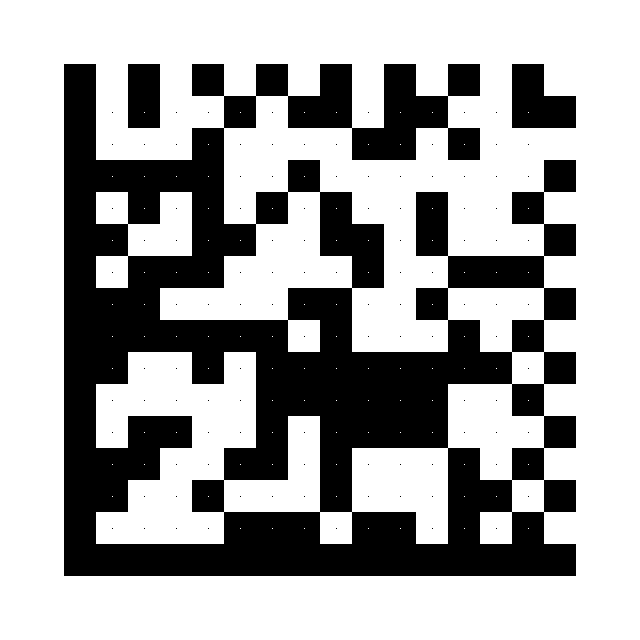

In [4]:
# testing
test = gen_string()
img = encode_image(test)
raw_coords, label_info = get_box_vals(img, debug=True)
print(raw_coords)
print(label_info)
img

In [5]:
def gen_save(type):
    '''Generates a random serial number, encodes it into a DMC image, and saves it to train/val/test folders'''

    to_encode = gen_string()
    img = encode_image(to_encode)

    # Save image
    img.save(f'../data/yolo_decoding/object_detection/simple_synth/images/{type}/{to_encode}.png')

    # Get box values
    raw_coords, label_info = get_box_vals(img)

    # Save box coordinates
    with open(f'../data/yolo_decoding/object_detection/simple_synth/labels/{type}/{to_encode}.txt', 'w') as f:
        for line in label_info:
            line = ' '.join([str(x) for x in line])
            f.write(f'{line}\n')

    return

def delete_old():
    '''Deletes all images and labels in train/val/test folders'''

    for folder in ['train', 'val', 'test']:
        for file in os.listdir(f'../data/yolo_decoding/object_detection/simple_synth/images/{folder}'):
            os.remove(f'../data/yolo_decoding/object_detection/simple_synth/images/{folder}/{file}')

        for file in os.listdir(f'../data/yolo_decoding/object_detection/simple_synth/labels/{folder}'):
            os.remove(f'../data/yolo_decoding/object_detection/simple_synth/labels/{folder}/{file}')
    
    # Delete cache too (if it exists)
    if os.path.exists('../data/yolo_decoding/object_detection/simple_synth/labels/train.cache'):
        os.remove('../data/yolo_decoding/object_detection/simple_synth/labels/train.cache')
        os.remove('../data/yolo_decoding/object_detection/simple_synth/labels/val.cache')

    return

In [6]:
# delete old images and labels
delete_old()

In [7]:
# generating train/val/test datasets
n_train = 800
n_val = 100
n_test = 100

# train
for i in range(n_train - len(os.listdir('../data/yolo_decoding/object_detection/simple_synth/images/train'))):
    gen_save('train')

# val
for i in range(n_val - len(os.listdir('../data/yolo_decoding/object_detection/simple_synth/images/val'))):
    gen_save('val')

# test
for i in range(n_test - len(os.listdir('../data/yolo_decoding/object_detection/simple_synth/images/test'))):
    gen_save('test')

# Loading untrained model

In [8]:
model = YOLO('yolo11n.yaml', task='detect')

# Training
Notes on trained models
- train: first model trained, likely mistake with widths
- train2: fixed widths and heights. Model still doesn't detect any modules.
- train3: removed early stopping.

In [20]:
results = model.train(
    data=f'{root_dir}\\data\\yolo_decoding\\object_detection\\simple_synth\\data.yml', # path to yaml file which specifies dataset parameters
    epochs=100,
    imgsz=640,                                         # image size (default 640 for yolo)
    single_cls=False,                                  # multi-class training
    patience=0,                                        # early stopping patience (after this many epochs with no improvement stop training)
    pretrained=False,                                  # don't use pre-trained weights
    plots=True,                                        # create plots

    # solving GPU memory issue?
    workers=0,                                         # number of worker threads for data loading (0 reduces memory problems at cost of slower training)
    batch=8,                                           # batch size (default 16, reducing to 8 can help)
)

New https://pypi.org/project/ultralytics/8.3.77 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.75  Python-3.9.21 torch-2.6.0+cu118 CUDA:0 (NVIDIA GeForce RTX 2070, 8192MiB)
engine\trainer: task=detect, mode=train, model=../yolo/runs/detect/train2/weights/best.pt, data=c:\Users\aidan\OneDrive\Desktop\itu\msc\courses\sem4\thesis\msc-thesis\data\yolo_decoding\object_detection\simple_synth\data.yml, epochs=100, time=None, patience=0, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=0, project=None, name=train3, exist_ok=False, pretrained=False, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1

100%|██████████| 5.35M/5.35M [00:00<00:00, 9.35MB/s]


AMP: checks passed 


train: Scanning C:\Users\aidan\OneDrive\Desktop\itu\msc\courses\sem4\thesis\msc-thesis\data\yolo_decoding\object_detection\simple_synth\labels\train.cache... 800 images, 0 backgrounds, 0 corrupt: 100%|██████████| 800/800 [00:00<?, ?it/s]
val: Scanning C:\Users\aidan\OneDrive\Desktop\itu\msc\courses\sem4\thesis\msc-thesis\data\yolo_decoding\object_detection\simple_synth\labels\val.cache... 100 images, 0 backgrounds, 0 corrupt: 100%|██████████| 100/100 [00:00<?, ?it/s]

Plotting labels to c:\Users\aidan\OneDrive\Desktop\itu\msc\courses\sem4\thesis\msc-thesis\yolo\runs\detect\train3\labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=5e-05, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to c:\Users\aidan\OneDrive\Desktop\itu\msc\courses\sem4\thesis\msc-thesis\yolo\runs\detect\train3
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      6.16G      1.548      4.386      1.254       2783        640: 100%|██████████| 100/100 [00:28<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.43it/s]

                   all        100      19600    0.00216    0.00913    0.00122    0.00102



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      6.47G      1.458      4.357       1.25       2388        640: 100%|██████████| 100/100 [00:25<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.24it/s]

                   all        100      19600    0.00536    0.00913    0.00284    0.00246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      5.08G      1.447      4.332      1.233       1561        640: 100%|██████████| 100/100 [00:25<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.03it/s]

                   all        100      19600    0.00448    0.00878    0.00241    0.00207



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      3.71G      1.436      4.279      1.215       2563        640: 100%|██████████| 100/100 [00:24<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.03it/s]

                   all        100      19600    0.00336    0.00806    0.00184    0.00158



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      3.67G      1.368      4.244       1.21       2905        640: 100%|██████████| 100/100 [00:24<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.01s/it]

                   all        100      19600    0.00643    0.00918    0.00343    0.00286



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100       5.8G      1.385      4.217       1.19       1586        640: 100%|██████████| 100/100 [00:24<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.08s/it]

                   all        100      19600    0.00723    0.00903    0.00384    0.00314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      5.36G      1.385      4.185      1.178       2203        640: 100%|██████████| 100/100 [00:25<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.08s/it]

                   all        100      19600     0.0057    0.00939    0.00308    0.00253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      5.48G      1.328      4.144      1.157       2769        640: 100%|██████████| 100/100 [00:25<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.08s/it]

                   all        100      19600    0.00755    0.00939    0.00405    0.00331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      5.28G      1.344      4.133      1.149       2370        640: 100%|██████████| 100/100 [00:25<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.08s/it]

                   all        100      19600    0.00539    0.00888    0.00295    0.00244



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      4.95G      1.332      4.107      1.148       1317        640: 100%|██████████| 100/100 [00:24<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.06s/it]

                   all        100      19600    0.00534    0.00939    0.00291    0.00242



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      3.82G      1.255      4.064      1.131       1828        640: 100%|██████████| 100/100 [00:24<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.07s/it]

                   all        100      19600    0.00524    0.00893    0.00286    0.00236



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      6.72G      1.253      4.069      1.129       2218        640: 100%|██████████| 100/100 [00:24<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.04s/it]

                   all        100      19600    0.00531    0.00862    0.00291    0.00244



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      5.44G      1.259      4.051      1.122       2401        640: 100%|██████████| 100/100 [00:24<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.05s/it]

                   all        100      19600    0.00529    0.00918    0.00289    0.00244



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      6.26G      1.276      4.044      1.118       2414        640: 100%|██████████| 100/100 [00:24<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.04s/it]

                   all        100      19600    0.00484    0.00903    0.00265    0.00224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100       3.8G      1.235      4.018      1.102       1891        640: 100%|██████████| 100/100 [00:23<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.04s/it]

                   all        100      19600    0.00434    0.00923    0.00239    0.00207



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      4.95G      1.168      3.982      1.094       2292        640: 100%|██████████| 100/100 [00:23<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.05s/it]

                   all        100      19600    0.00413    0.00903     0.0023    0.00199



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      6.09G      1.174      3.969      1.085       1515        640: 100%|██████████| 100/100 [00:24<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.05s/it]

                   all        100      19600    0.00491    0.00913    0.00273    0.00236



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      5.19G      1.156      3.948      1.086       2115        640: 100%|██████████| 100/100 [00:24<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.07s/it]

                   all        100      19600    0.00439    0.00908    0.00243    0.00213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      6.06G      1.148      3.937      1.076       2483        640: 100%|██████████| 100/100 [00:24<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.05s/it]

                   all        100      19600    0.00578    0.00944    0.00315     0.0027



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      5.63G      1.165      3.926      1.082       1914        640: 100%|██████████| 100/100 [00:23<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.05s/it]

                   all        100      19600     0.0052    0.00969    0.00285    0.00252



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      4.72G      1.102      3.881      1.078       2585        640: 100%|██████████| 100/100 [00:24<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.05s/it]

                   all        100      19600    0.00473    0.00898    0.00259    0.00223



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      4.73G      1.067      3.856      1.065       2014        640: 100%|██████████| 100/100 [00:23<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.06s/it]

                   all        100      19600    0.00377    0.00918    0.00213    0.00189



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      3.81G      1.071      3.855      1.053       2492        640: 100%|██████████| 100/100 [00:24<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.06s/it]

                   all        100      19600    0.00442     0.0101    0.00248    0.00222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      5.76G      1.094      3.849      1.058       1846        640: 100%|██████████| 100/100 [00:23<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.06s/it]

                   all        100      19600    0.00466     0.0105    0.00263    0.00232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      5.19G      1.061       3.83      1.056       2337        640: 100%|██████████| 100/100 [00:23<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.06s/it]

                   all        100      19600    0.00459     0.0106    0.00259    0.00232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100       6.6G      1.042      3.819      1.046       1650        640: 100%|██████████| 100/100 [00:23<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.06s/it]

                   all        100      19600    0.00386     0.0103    0.00225    0.00202



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      5.66G     0.9848      3.778      1.044       1811        640: 100%|██████████| 100/100 [00:24<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.07s/it]

                   all        100      19600    0.00386     0.0103    0.00226    0.00201



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      4.56G     0.9741      3.763      1.033       1628        640: 100%|██████████| 100/100 [00:23<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.06s/it]

                   all        100      19600    0.00332     0.0098    0.00201    0.00179



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      5.01G      1.031      3.775      1.045       2679        640: 100%|██████████| 100/100 [00:23<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.06s/it]

                   all        100      19600    0.00374     0.0106    0.00222      0.002



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      5.17G     0.9798      3.745      1.048       1755        640: 100%|██████████| 100/100 [00:23<00:00,  4.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.06s/it]

                   all        100      19600    0.00354     0.0104    0.00211    0.00189



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      4.96G     0.9986      3.743      1.034       2086        640: 100%|██████████| 100/100 [00:24<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.06s/it]

                   all        100      19600    0.00434      0.011    0.00254    0.00227



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      6.42G     0.9932      3.739      1.031       2650        640: 100%|██████████| 100/100 [00:23<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.06s/it]

                   all        100      19600    0.00502     0.0113    0.00289    0.00258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100       3.8G     0.9747      3.719      1.021       2080        640: 100%|██████████| 100/100 [00:23<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.06s/it]

                   all        100      19600    0.00613     0.0115    0.00347    0.00305



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      4.15G     0.9242      3.692       1.02       2043        640: 100%|██████████| 100/100 [00:23<00:00,  4.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.06s/it]

                   all        100      19600    0.00447     0.0119    0.00263    0.00232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      4.69G     0.9595      3.697      1.017       1444        640: 100%|██████████| 100/100 [00:24<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.06s/it]

                   all        100      19600      0.009     0.0108    0.00489    0.00469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      5.44G     0.9282       3.68      1.016       2132        640: 100%|██████████| 100/100 [00:24<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.06s/it]

                   all        100      19600    0.00945     0.0106    0.00511    0.00485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      4.95G     0.9502      3.684      1.015       2443        640: 100%|██████████| 100/100 [00:24<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.07s/it]

                   all        100      19600    0.00871     0.0107    0.00475    0.00429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      5.53G     0.8867      3.648      1.008       1620        640: 100%|██████████| 100/100 [00:23<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.08s/it]

                   all        100      19600    0.00962     0.0106    0.00523    0.00499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      5.73G       0.91      3.655      1.005       1509        640: 100%|██████████| 100/100 [00:24<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.07s/it]

                   all        100      19600     0.0104     0.0108    0.00562    0.00528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      4.47G     0.8872      3.646      1.006       1235        640: 100%|██████████| 100/100 [00:24<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.07s/it]

                   all        100      19600    0.00869     0.0107    0.00475    0.00429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      5.61G     0.8697      3.632      1.004       2343        640: 100%|██████████| 100/100 [00:24<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.06s/it]

                   all        100      19600    0.00938     0.0109    0.00511    0.00489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      6.91G     0.9027      3.633     0.9957       2331        640: 100%|██████████| 100/100 [00:24<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.07s/it]

                   all        100      19600    0.00882     0.0114    0.00485    0.00466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      5.41G     0.8693      3.619      1.002       2238        640: 100%|██████████| 100/100 [00:24<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.07s/it]

                   all        100      19600     0.0095      0.011    0.00518    0.00469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      5.71G      0.869      3.616      1.009       2499        640: 100%|██████████| 100/100 [00:24<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.06s/it]

                   all        100      19600    0.00877      0.011    0.00482    0.00463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      4.32G     0.8483      3.604      1.002       1576        640: 100%|██████████| 100/100 [00:24<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.08s/it]

                   all        100      19600    0.00831     0.0108     0.0046    0.00441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      4.23G     0.8462      3.599     0.9906       2082        640: 100%|██████████| 100/100 [00:24<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.07s/it]

                   all        100      19600    0.00363     0.0109    0.00225    0.00206



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      5.34G       0.85      3.594     0.9894       1195        640: 100%|██████████| 100/100 [00:24<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.06s/it]

                   all        100      19600    0.00343     0.0105    0.00219    0.00199



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      5.71G     0.8626      3.597     0.9935       1656        640: 100%|██████████| 100/100 [00:24<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.06s/it]

                   all        100      19600    0.00413     0.0107    0.00253    0.00232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      3.84G     0.8412      3.587     0.9937       1562        640: 100%|██████████| 100/100 [00:24<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.06s/it]

                   all        100      19600    0.00392     0.0106    0.00243    0.00222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      4.92G     0.8234       3.58     0.9905       2270        640: 100%|██████████| 100/100 [00:24<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.07s/it]

                   all        100      19600    0.00477     0.0114    0.00287    0.00263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      5.13G     0.8145      3.568     0.9834       1200        640: 100%|██████████| 100/100 [00:24<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.06s/it]

                   all        100      19600    0.00434     0.0112    0.00267    0.00244



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      6.06G     0.7942      3.565       0.98       1982        640: 100%|██████████| 100/100 [00:24<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.06s/it]

                   all        100      19600    0.00439     0.0107    0.00272    0.00248



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100       5.6G     0.8083      3.564      0.983       1943        640: 100%|██████████| 100/100 [00:24<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.06s/it]

                   all        100      19600    0.00493     0.0111      0.003    0.00273



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      4.87G     0.8008      3.556     0.9768       2395        640: 100%|██████████| 100/100 [00:24<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.06s/it]

                   all        100      19600    0.00512     0.0117    0.00308    0.00283



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      5.23G     0.7793       3.55     0.9815       1984        640: 100%|██████████| 100/100 [00:23<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.07s/it]

                   all        100      19600    0.00485     0.0112    0.00294    0.00271



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100         7G     0.7783      3.548     0.9832       1879        640: 100%|██████████| 100/100 [00:24<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.06s/it]

                   all        100      19600    0.00677      0.012    0.00393    0.00359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100       3.9G     0.7603      3.539     0.9765       1128        640: 100%|██████████| 100/100 [00:23<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.06s/it]

                   all        100      19600    0.00908     0.0118    0.00511    0.00464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      5.61G     0.7746      3.542     0.9806       1941        640: 100%|██████████| 100/100 [00:23<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.06s/it]

                   all        100      19600    0.00694     0.0122    0.00404    0.00369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      6.08G     0.7597      3.537     0.9799       1828        640: 100%|██████████| 100/100 [00:24<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.06s/it]

                   all        100      19600    0.00584      0.012    0.00346    0.00317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      9.01G     0.7544      3.535     0.9827       1862        640: 100%|██████████| 100/100 [00:34<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.07s/it]

                   all        100      19600    0.00438     0.0124    0.00272    0.00251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      4.39G     0.7837      3.536      0.975       1859        640: 100%|██████████| 100/100 [00:24<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.06s/it]

                   all        100      19600    0.00459     0.0126    0.00285    0.00262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      5.09G     0.7499      3.523     0.9654       1822        640: 100%|██████████| 100/100 [00:24<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.06s/it]

                   all        100      19600    0.00457     0.0123    0.00281     0.0026



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      5.99G     0.7584      3.528      0.976       2754        640: 100%|██████████| 100/100 [00:23<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.06s/it]

                   all        100      19600     0.0048     0.0127    0.00294    0.00271



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      5.29G     0.7569       3.52     0.9651       1733        640: 100%|██████████| 100/100 [00:24<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.06s/it]

                   all        100      19600     0.0101     0.0121    0.00563    0.00515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      3.66G     0.7591      3.528     0.9804       2783        640: 100%|██████████| 100/100 [00:23<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.06s/it]

                   all        100      19600    0.00527     0.0132     0.0032    0.00296



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      5.86G     0.7504      3.519       0.97       3126        640: 100%|██████████| 100/100 [00:24<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.06s/it]

                   all        100      19600    0.00498      0.013    0.00305    0.00284



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      6.07G     0.7367      3.514     0.9719       2393        640: 100%|██████████| 100/100 [00:24<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.05s/it]

                   all        100      19600    0.00521     0.0129    0.00317    0.00297



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      3.76G     0.7268      3.509     0.9685       1603        640: 100%|██████████| 100/100 [00:23<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.05s/it]

                   all        100      19600     0.0051     0.0132    0.00311    0.00291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      4.75G     0.7512      3.517     0.9731       2574        640: 100%|██████████| 100/100 [00:24<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.05s/it]

                   all        100      19600     0.0109     0.0132    0.00607    0.00559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      5.16G     0.7194      3.508     0.9695       1731        640: 100%|██████████| 100/100 [00:24<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.04s/it]

                   all        100      19600    0.00604     0.0139    0.00369    0.00346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      6.33G     0.7217      3.507     0.9707       2828        640: 100%|██████████| 100/100 [00:23<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.04s/it]

                   all        100      19600    0.00627     0.0145    0.00377     0.0035



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      5.88G     0.7072      3.501     0.9728       2007        640: 100%|██████████| 100/100 [00:23<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.04s/it]

                   all        100      19600    0.00594     0.0143     0.0036    0.00337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      5.27G     0.7204      3.503     0.9695       2417        640: 100%|██████████| 100/100 [00:24<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.19s/it]

                   all        100      19600    0.00608     0.0144     0.0037    0.00345



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      4.22G     0.7279      3.502      0.961       1639        640: 100%|██████████| 100/100 [00:26<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.15s/it]

                   all        100      19600     0.0058     0.0143    0.00354    0.00332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      5.02G     0.7131      3.499     0.9682       2629        640: 100%|██████████| 100/100 [00:25<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.08s/it]

                   all        100      19600    0.00675     0.0147    0.00403    0.00376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      6.34G     0.6983      3.494     0.9643       1911        640: 100%|██████████| 100/100 [00:25<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.16s/it]

                   all        100      19600    0.00708     0.0142    0.00421    0.00393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      6.08G     0.7028      3.495     0.9659       1958        640: 100%|██████████| 100/100 [00:25<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.12s/it]

                   all        100      19600    0.00593     0.0147    0.00364    0.00338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      5.15G     0.7144      3.501     0.9663       1568        640: 100%|██████████| 100/100 [00:24<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.30s/it]

                   all        100      19600    0.00669      0.015    0.00402    0.00379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      4.43G     0.6998      3.489     0.9629       1755        640: 100%|██████████| 100/100 [00:27<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.27s/it]

                   all        100      19600    0.00723     0.0154    0.00434    0.00404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      5.43G     0.6922      3.489      0.967       2326        640: 100%|██████████| 100/100 [00:25<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.28s/it]

                   all        100      19600    0.00651      0.015    0.00393    0.00369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      4.93G     0.6972      3.493     0.9633       1745        640: 100%|██████████| 100/100 [00:26<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.24s/it]

                   all        100      19600    0.00521     0.0147    0.00329    0.00306



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      5.65G       0.69      3.489     0.9618       1761        640: 100%|██████████| 100/100 [00:26<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.29s/it]

                   all        100      19600    0.00653     0.0145    0.00396    0.00372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      6.32G     0.6978       3.49     0.9636       2663        640: 100%|██████████| 100/100 [00:27<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.31s/it]

                   all        100      19600    0.00603     0.0148    0.00373    0.00348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      6.76G     0.7168      3.492     0.9665       3253        640: 100%|██████████| 100/100 [00:27<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.30s/it]

                   all        100      19600    0.00633     0.0154    0.00391    0.00365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      4.54G     0.6843      3.487     0.9697       1746        640: 100%|██████████| 100/100 [00:26<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.31s/it]

                   all        100      19600    0.00609     0.0152    0.00377    0.00347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      5.69G     0.6743      3.477     0.9576       2506        640: 100%|██████████| 100/100 [00:26<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.31s/it]

                   all        100      19600    0.00621     0.0156    0.00389    0.00361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      3.92G     0.7155      3.493      0.966       1893        640: 100%|██████████| 100/100 [00:27<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.29s/it]

                   all        100      19600    0.00635     0.0161    0.00394    0.00367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      4.73G     0.6999      3.487     0.9643       1855        640: 100%|██████████| 100/100 [00:26<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.30s/it]

                   all        100      19600    0.00669     0.0158    0.00412    0.00381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      4.34G     0.7038      3.486      0.961       2783        640: 100%|██████████| 100/100 [00:27<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.29s/it]

                   all        100      19600    0.00683     0.0164    0.00426    0.00396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      6.96G     0.6979      3.484     0.9597       2635        640: 100%|██████████| 100/100 [00:27<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.30s/it]

                   all        100      19600    0.00684     0.0168    0.00422    0.00389


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      1.95G     0.6198      3.551       1.02       1527        640: 100%|██████████| 100/100 [00:22<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.29s/it]

                   all        100      19600    0.00647     0.0136    0.00375    0.00344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      1.95G     0.6209      3.548      1.024       1554        640: 100%|██████████| 100/100 [00:22<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.28s/it]

                   all        100      19600    0.00689     0.0133    0.00388    0.00352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      1.95G     0.6067       3.54      1.023       1540        640: 100%|██████████| 100/100 [00:22<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.28s/it]

                   all        100      19600    0.00543     0.0133     0.0031    0.00288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      1.95G     0.6043      3.539      1.024       1541        640: 100%|██████████| 100/100 [00:22<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.21s/it]

                   all        100      19600    0.00603     0.0139    0.00344    0.00317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      1.95G     0.5754      3.513     0.9979       1568        640: 100%|██████████| 100/100 [00:23<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.27s/it]

                   all        100      19600    0.00603      0.014    0.00346    0.00316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      1.95G     0.6025      3.531      1.016       1554        640: 100%|██████████| 100/100 [00:22<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.28s/it]

                   all        100      19600    0.00596     0.0142    0.00342    0.00316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      1.95G     0.6007      3.533      1.013       1568        640: 100%|██████████| 100/100 [00:22<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.32s/it]

                   all        100      19600    0.00593     0.0145    0.00341    0.00314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      1.95G      0.587      3.532      1.009       1514        640: 100%|██████████| 100/100 [00:23<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.30s/it]

                   all        100      19600    0.00663     0.0145    0.00373    0.00345



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      1.95G     0.5931      3.537      1.023       1554        640: 100%|██████████| 100/100 [00:22<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.31s/it]

                   all        100      19600     0.0105     0.0137    0.00572    0.00522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      1.95G       0.57      3.522      1.007       1568        640: 100%|██████████| 100/100 [00:22<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.32s/it]

                   all        100      19600    0.00591     0.0139    0.00341    0.00316



100 epochs completed in 0.914 hours.
Optimizer stripped from c:\Users\aidan\OneDrive\Desktop\itu\msc\courses\sem4\thesis\msc-thesis\yolo\runs\detect\train3\weights\last.pt, 5.7MB
Optimizer stripped from c:\Users\aidan\OneDrive\Desktop\itu\msc\courses\sem4\thesis\msc-thesis\yolo\runs\detect\train3\weights\best.pt, 5.7MB

Validating c:\Users\aidan\OneDrive\Desktop\itu\msc\courses\sem4\thesis\msc-thesis\yolo\runs\detect\train3\weights\best.pt...
Ultralytics 8.3.75  Python-3.9.21 torch-2.6.0+cu118 CUDA:0 (NVIDIA GeForce RTX 2070, 8192MiB)
YOLO11n summary (fused): 238 layers, 2,676,676 parameters, 0 gradients, 6.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:11<00:00,  1.63s/it]


                   all        100      19600     0.0109     0.0133     0.0061    0.00561
               class_0        100        100          0          0          0          0
               class_1        100        100          0          0          0          0
               class_2        100        100          0          0          0          0
               class_3        100        100    0.00512       0.02    0.00264    0.00237
               class_4        100        100          0          0          0          0
               class_5        100        100     0.0326       0.11     0.0215     0.0183
               class_6        100        100          0          0          0          0
               class_7        100        100          0          0          0          0
               class_8        100        100     0.0128       0.17    0.00768    0.00711
               class_9        100        100          0          0          0          0
              class_1

In [21]:
# Super minor cleanup
if os.path.exists('yolo11n.pt'):
    os.remove('yolo11n.pt')

# Evaluating

In [22]:
# Loading trained model
model = YOLO('../yolo/runs/detect/train3/weights/best.pt', task='detect')

In [23]:
# # validation
# metrics = model.val()
# print(metrics)

In [24]:
# test
test_images = os.listdir('../data/yolo_decoding/object_detection/simple_synth/images/test')
test_images = [f'../data/yolo_decoding/object_detection/simple_synth/images/test/{x}' for x in test_images]
results = model(test_images)


0: 640x640 (no detections), 3.5ms
1: 640x640 (no detections), 3.5ms
2: 640x640 (no detections), 3.5ms
3: 640x640 (no detections), 3.5ms
4: 640x640 (no detections), 3.5ms
5: 640x640 (no detections), 3.5ms
6: 640x640 (no detections), 3.5ms
7: 640x640 (no detections), 3.5ms
8: 640x640 (no detections), 3.5ms
9: 640x640 (no detections), 3.5ms
10: 640x640 (no detections), 3.5ms
11: 640x640 (no detections), 3.5ms
12: 640x640 (no detections), 3.5ms
13: 640x640 (no detections), 3.5ms
14: 640x640 (no detections), 3.5ms
15: 640x640 (no detections), 3.5ms
16: 640x640 (no detections), 3.5ms
17: 640x640 (no detections), 3.5ms
18: 640x640 (no detections), 3.5ms
19: 640x640 (no detections), 3.5ms
20: 640x640 (no detections), 3.5ms
21: 640x640 (no detections), 3.5ms
22: 640x640 (no detections), 3.5ms
23: 640x640 (no detections), 3.5ms
24: 640x640 (no detections), 3.5ms
25: 640x640 (no detections), 3.5ms
26: 640x640 (no detections), 3.5ms
27: 640x640 (no detections), 3.5ms
28: 640x640 (no detections), 

In [25]:
for result in results:
    boxes = result.boxes
    keypoints = result.keypoints
    result.show()
    break